# **Maxime's Notebook - StarGAN + Class Equalizer + CNN Classifier (with utils.load_and_pre_process_images)**

Adapted version using `load_and_pre_process_images` from utils.py for efficient image loading and preprocessing.

In [8]:
# Install necessary packages
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchvision
import random
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import gc
from tqdm.auto import tqdm
import csv
from pathlib import Path
import cv2

# 📁 Configuration du dossier de sortie et imports
notebooks_dir = os.getcwd()
parent_dir = os.path.dirname(notebooks_dir)
OUTPUT_DIR = os.path.join(parent_dir, "outputs")

# Add src to path for utils import
src_path = os.path.join(parent_dir, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from utils import load_and_pre_process_images

# Vérifier et créer le dossier OUTPUT_DIR
if os.path.exists(OUTPUT_DIR) and not os.path.isdir(OUTPUT_DIR):
    try:
        os.remove(OUTPUT_DIR)
        print(f"⚠️ Fichier supprimé pour libérer le chemin dossier: {OUTPUT_DIR}")
    except Exception as e:
        print(f"⚠️ Impossible de supprimer le fichier {OUTPUT_DIR}: {e}")
        raise
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Dossier de sortie configuré: {OUTPUT_DIR}")
print(f"✅ Utils importé depuis: {src_path}\n")

📁 Dossier de sortie configuré: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs
✅ Utils importé depuis: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\src



In [9]:
## Étape 0-3 : Initialisation et preprocessing avec load_and_pre_process_images

import stat

def remove_readonly(func, path, _):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# Chemins des dossiers
original_dataset_path = os.path.join(parent_dir, "data", "Orignal-Dataset")
StarGAN_dir = os.path.join(parent_dir, "data", "StarGAN-Dataset")


# Mapping des noms de classes
folder_mapping = {
    "Alluvial_Soil": "type1",
    "Arid_Soil": "type2",
    "Black_Soil": "type3",
    "Laterite_Soil": "type4",
    "Mountain_Soil": "type5",
    "Red_Soil": "type6",
    "Yellow_Soil": "type7"
}

# Vérification et préparation du dossier StarGAN-Dataset
if os.path.exists(StarGAN_dir):
    shutil.rmtree(StarGAN_dir, onerror=remove_readonly)
    print(f"🧹 Dossier vidé: {StarGAN_dir}")
os.makedirs(StarGAN_dir, exist_ok=True)
print(f"📁 Dossier recréé: {StarGAN_dir}\n")

# Copier et renommer les classes
print("📋 Copie et renommage des classes...")
for old_name, new_name in folder_mapping.items():
    old_path = os.path.join(original_dataset_path, old_name)
    new_path = os.path.join(StarGAN_dir, new_name)
    if os.path.exists(old_path):
        shutil.copytree(old_path, new_path)
        print(f"  ✅ {old_name} → {new_name}")
    else:
        print(f"  ⚠️ {old_name} non trouvé")

print("\n" + "="*70)
print("📦 UTILISATION DE load_and_pre_process_images")
print("="*70 + "\n")

# Utiliser load_and_pre_process_images pour prétraiter toutes les classes
# Les images seront converties en JPG, redimensionnées et crop au centre
target_size = (256, 256)

all_images_by_class = {}
for class_name in folder_mapping.values():
    class_path = os.path.join(StarGAN_dir, class_name)
    
    # Charger et prétraiter les images avec la fonction utils
    images_and_names = load_and_pre_process_images(
        class_path,
        256)
    
    all_images_by_class[class_name] = images_and_names
    print(f"  {class_name}: {len(images_and_names)} images chargées et prétraitées")

print(f"\n✅ Prétraitement terminé pour toutes les classes")
print("="*70 + "\n")

🧹 Dossier vidé: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\data\StarGAN-Dataset
📁 Dossier recréé: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\data\StarGAN-Dataset

📋 Copie et renommage des classes...
  ✅ Alluvial_Soil → type1
  ✅ Arid_Soil → type2
  ✅ Black_Soil → type3
  ✅ Laterite_Soil → type4
  ✅ Mountain_Soil → type5
  ✅ Red_Soil → type6
  ✅ Yellow_Soil → type7

📦 UTILISATION DE load_and_pre_process_images

  type1: 52 images chargées et prétraitées
  type2: 284 images chargées et prétraitées
  type3: 255 images chargées et prétraitées
  type4: 219 images chargées et prétraitées
  type5: 201 images chargées et prétraitées
  type6: 109 images chargées et prétraitées
  type7: 69 images chargées et prétraitées

✅ Prétraitement terminé pour toutes les classes



In [33]:
## Étape 4 : Train/Test split

print("📊 Création de la structure train/test...\n")

for i in range(1, 8):
    os.makedirs(os.path.join(StarGAN_dir, "train", f"type{i}"), exist_ok=True)
    os.makedirs(os.path.join(StarGAN_dir, "test", f"type{i}"), exist_ok=True)

# Répartir les images entre train et test (30% test, 70% train)
for class_name, images_and_names in all_images_by_class.items():
    if not images_and_names:
        print(f"⚠️ {class_name} est vide")
        continue
    
    # Splitter les noms de fichiers
    filenames = [name for _, name in images_and_names]
    train_files, test_files = train_test_split(filenames, test_size=0.3, random_state=42)
    
    # Récréer les images pour la copie
    images_dict = {name: img for img, name in images_and_names}
    
    # Sauvegarder les images train
    train_dir = os.path.join(StarGAN_dir, "train", class_name)
    for fname in train_files:
        img_array = images_dict[fname]
        if img_array.dtype != np.uint8:
            img_uint8 = np.clip(img_array, 0, 1) * 255 if img_array.max() <= 1.0 else np.clip(img_array, 0, 255)
            img_uint8 = img_uint8.astype(np.uint8)
        else:
            img_uint8 = img_array
        img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_pil.save(os.path.join(train_dir, fname), 'JPEG', quality=95)
    
    # Sauvegarder les images test
    test_dir = os.path.join(StarGAN_dir, "test", class_name)
    for fname in test_files:
        img_array = images_dict[fname]
        if img_array.dtype != np.uint8:
            img_uint8 = np.clip(img_array, 0, 1) * 255 if img_array.max() <= 1.0 else np.clip(img_array, 0, 255)
            img_uint8 = img_uint8.astype(np.uint8)
        else:
            img_uint8 = img_array
        img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_pil.save(os.path.join(test_dir, fname), 'JPEG', quality=95)
    
    print(f"✅ {class_name}: {len(train_files)} train, {len(test_files)} test")

print("\n✅ Répartition train/test terminée")
print("="*70 + "\n")

📊 Création de la structure train/test...

✅ type1: 36 train, 16 test
✅ type2: 198 train, 86 test
✅ type3: 178 train, 77 test
✅ type4: 153 train, 66 test
✅ type5: 140 train, 61 test
✅ type6: 76 train, 33 test
✅ type7: 48 train, 21 test

✅ Répartition train/test terminée



## Étape 5 : Création d'une classe Dataset personnalisée

In [11]:
class SolDataset(Dataset):
    def __init__(self, root_dir, transform=None, allowed_domains=None):
        self.transform = transform
        self.images = []
        self.domains = []
        self.domain_names = []

        # Parcourir les sous-dossiers de root_dir (train ou test)
        for domain_idx, domain in enumerate(sorted(os.listdir(root_dir)), start=1):
            domain_path = os.path.join(root_dir, domain)
            # Mémoriser les noms de domaines triés
            self.domain_names.append(domain)
            # Appliquer filtre de domaines si fourni
            if allowed_domains is not None and (domain_idx - 1) not in allowed_domains:
                continue
            for img_name in os.listdir(domain_path):
                self.images.append(os.path.join(domain_path, img_name))
                self.domains.append(domain_idx - 1)  # Les labels commencent à 0

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        domain = self.domains[index]
        if self.transform:
            img = self.transform(img)
        return img, domain

    def __len__(self):
        return len(self.images)

## Étape 6.1 : Définir les transformations

In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner à 128x128
    transforms.ToTensor(),          # Convertir en tenseur
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliser entre -1 et 1
])

## Etape 6.2 : Créer les datasets et dataloaders

In [13]:
# Identifier les domaines riches (beaucoup d'images) et exclure le domaine cible appauvri (Alluvial = type1)
train_root = os.path.join(StarGAN_dir, "train")
counts = {}
for d in sorted(os.listdir(train_root)):
    counts[d] = len(os.listdir(os.path.join(train_root, d)))

# Définir type1 (Alluvial_Soil) comme domaine cible appauvri
target_domain_name = "type1"
rich_domains_names = [d for d, c in counts.items() if d != target_domain_name and c > 50]  # seuil ajustable
name_to_index = {f"type{i}": i-1 for i in range(1,8)}
allowed_domains = [name_to_index[n] for n in rich_domains_names]

train_dataset = SolDataset(train_root, transform=transform, allowed_domains=allowed_domains)
test_dataset = SolDataset(os.path.join(StarGAN_dir, "test"), transform=transform)

# DataLoader - num_workers=0 pour éviter les problèmes Windows/Jupyter
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("Domaines riches utilisés pour source:", rich_domains_names)
print("Taille du train_dataset:", len(train_dataset))

Domaines riches utilisés pour source: ['type2', 'type3', 'type4', 'type5', 'type6']
Taille du train_dataset: 745


## Étape 7.1 : Définition du générateur et du discriminateur

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.backends.cudnn.benchmark = True

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_domains=5, dim=32, num_res_blocks=3):
        super(Generator, self).__init__()
        self.dim = dim
        # Couches initiales
        self.conv1 = nn.Conv2d(3, dim, 7, 1, 3)
        self.norm1 = nn.InstanceNorm2d(dim)

        # Blocs résiduels
        self.res_blocks = nn.Sequential(*[ResidualBlock(dim) for _ in range(num_res_blocks)])

        # Couche pour intégrer le vecteur de domaine
        self.domain_embedding = nn.Sequential(
            nn.Linear(num_domains, dim * 256),
            nn.ReLU(inplace=True),
            nn.Linear(dim * 256, dim),
            nn.ReLU(inplace=True)
        )

        # Couches finales
        self.conv2 = nn.Conv2d(dim, 3, 7, 1, 3)

    def forward(self, x, domain):
        # Encoder l'image
        x = F.relu(self.norm1(self.conv1(x)))

        # Passer par les blocs résiduels
        x = self.res_blocks(x)

        # Intégrer le vecteur de domaine (broadcasting sur les canaux)
        domain_embedding = self.domain_embedding(domain)  # Shape: (batch_size, dim)
        domain_embedding = domain_embedding.view(-1, self.dim, 1, 1)  # Reshape: (batch_size, dim, 1, 1)
        x = x + domain_embedding  # Broadcasting automatique sur les dimensions spatiales

        # Décoder l'image
        return torch.tanh(self.conv2(x))

class Discriminator(nn.Module):
    def __init__(self, num_domains=5, dim=32):
        super(Discriminator, self).__init__()
        # Couches initiales
        self.conv1 = nn.Conv2d(3, dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(dim, dim * 2, 4, 2, 1)
        self.norm2 = nn.InstanceNorm2d(dim * 2)

        # Couches pour la prédiction adversariale (réelle/fausse)
        self.adv_layer = nn.Conv2d(dim * 2, 1, 3, 1, 1)

        # Couches pour la prédiction de domaine (avec global pooling)
        self.domain_conv = nn.Conv2d(dim * 2, num_domains, 3, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Extraire les caractéristiques
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.norm2(self.conv2(x)), 0.2)

        # Prédiction adversariale
        adv_out = self.adv_layer(x)

        # Prédiction de domaine avec global pooling
        domain_features = self.domain_conv(x)
        domain_out = self.global_pool(domain_features)
        domain_out = domain_out.view(domain_out.size(0), -1)  # (batch, num_domains)

        return adv_out, domain_out

## Étape 7.2 : Initialiser le générateur et le discriminateur

In [15]:
num_domains = 7  # Vous avez 7 types de sols

# Vérifier si CUDA est disponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Utilisation du device: {device}")

G = Generator(num_domains).to(device)
D = Discriminator(num_domains).to(device)

Utilisation du device: cuda


## Étape 7.3 : Définir les fonctions de perte, les optimisateurs et les scalers AMP

In [16]:
loss_bce = nn.BCEWithLogitsLoss()
loss_ce = nn.CrossEntropyLoss()
loss_l1 = nn.L1Loss()

optim_G = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Mixed precision (AMP)
scaler_G = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
scaler_D = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

C:\Users\alera\AppData\Local\Temp\ipykernel_21204\298528357.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\alera\AppData\Local\Temp\ipykernel_21204\298528357.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


## Helper functions

In [17]:
def get_class_distribution(root_dir):
    """
    Calcule le nombre d'images par classe (type1-type7) dans un dossier.
    """
    class_counts = {}
    for class_dir in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
            class_counts[class_dir] = count
    return class_counts


def save_sample_images(G, real_images, target_domain, epoch, device, num_domains):
    """
    Generate and save sample images from the generator for visualization.
    Sauvegarde dans SAMPLE_DIR si disponible, sinon dans OUTPUT_DIR/samples.
    """
    with torch.no_grad():
        target_domain_one_hot = F.one_hot(target_domain[:4], num_domains).float().to(device)
        sample_images = G(real_images[:4], target_domain_one_hot)
        # Résoudre le dossier d'échantillons de manière robuste
        try:
            sample_dir = globals().get('SAMPLE_DIR', None)
            if sample_dir is None:
                sample_dir = os.path.join(globals().get('OUTPUT_DIR', '.'), 'samples')
        except Exception:
            sample_dir = 'samples'
        os.makedirs(sample_dir, exist_ok=True)
        sample_path = os.path.join(sample_dir, f"epoch_{epoch}.png")
        torchvision.utils.save_image(sample_images, sample_path, normalize=True, nrow=2)


def generate_images_for_class(G, loader, device, num_domains, target_class_idx, out_dir, max_images):
    """
    Génère des images synthétiques pour une classe cible spécifique.
    Utilise les images des autres domaines comme source pour la traduction.
    """
    os.makedirs(out_dir, exist_ok=True)
    G.eval()
    generated = 0
    with torch.no_grad():
        for b_idx, (real_images, source_domain) in enumerate(loader):
            if generated >= max_images:
                break
            real_images = real_images.to(device, non_blocking=True)
            # Cible fixe: la classe spécifiée
            target_domain = torch.full((real_images.size(0),), target_class_idx, dtype=torch.long, device=device)
            target_one_hot = F.one_hot(target_domain, num_domains).float().to(device)
            fake_images = G(real_images, target_one_hot)
            for i in range(fake_images.size(0)):
                if generated >= max_images:
                    break
                out_path = os.path.join(out_dir, f"aug_gen_{generated:04d}.jpg")
                torchvision.utils.save_image(fake_images[i], out_path, normalize=True)
                generated += 1
    print(f"Images générées pour la classe {target_class_idx}: {generated} images")
    G.train()
    return generated


def class_equalizer(G, loader, device, num_domains, train_dir):
    """
    Équilibre le nombre d'images pour chaque classe en générant des images synthétiques.
    Les images générées sont sauvegardées directement dans les dossiers train de chaque classe.
    """
    # Compter les images actuelles dans le dossier train
    class_counts = get_class_distribution(train_dir)
    
    print("\n" + "="*60)
    print("🔄 ÉQUILIBRAGE DES CLASSES (CLASS EQUALIZER)")
    print("="*60)
    print("Distribution initiale des images par classe:")
    for class_name, count in sorted(class_counts.items()):
        print(f"  {class_name}: {count} images")
    
    # Trouver le maximum
    max_count = max(class_counts.values())
    print(f"\n📊 Classe avec le plus d'images: {max_count} images")
    
    # Générer les images manquantes pour chaque classe
    total_generated = 0
    for class_idx in range(num_domains):
        class_name = f"type{class_idx + 1}"
        current_count = class_counts.get(class_name, 0)
        images_needed = max_count - current_count
        
        if images_needed > 0:
            print(f"\n🎯 Génération pour {class_name}: {images_needed} images manquantes")
            class_out_dir = os.path.join(train_dir, class_name)
            generated = generate_images_for_class(
                G, loader, device, num_domains, 
                class_idx, class_out_dir, images_needed
            )
            total_generated += generated
        else:
            print(f"✅ {class_name}: {current_count} images (maximum atteint)")
    
    # Vérification finale
    print("\n" + "="*60)
    print("✨ VÉRIFICATION FINALE")
    print("="*60)
    final_counts = get_class_distribution(train_dir)
    for class_name, count in sorted(final_counts.items()):
        print(f"  {class_name}: {count} images")
    
    print(f"\n✅ Total d'images générées: {total_generated}")
    print("="*60 + "\n")

## Étape 8.1 : Définir la boucle d'entraînement

In [18]:
def train_step(real_images, source_domain, target_domain, scaler_G, scaler_D, use_amp=True):
    # Transfert GPU (avec non_blocking si possible)
    real_images = real_images.to(device, non_blocking=True)
    source_domain = source_domain.to(device, non_blocking=True)
    target_domain = target_domain.to(device, non_blocking=True)

    # Génération des images synthétiques + calculs dans autocast
    with torch.cuda.amp.autocast(enabled=use_amp):
        target_domain_one_hot = F.one_hot(target_domain, num_domains).float().to(device)
        fake_images = G(real_images, target_domain_one_hot)

        # Discriminateur
        real_pred, real_domain_pred = D(real_images)
        fake_pred, fake_domain_pred = D(fake_images.detach())
        ones = torch.ones_like(fake_pred)

        loss_D_adv = loss_bce(fake_pred - real_pred.mean(0), ones)
        loss_D_domain_real = loss_ce(real_domain_pred, source_domain)
        loss_D_domain_fake = loss_ce(fake_domain_pred, target_domain)
        loss_D = loss_D_adv + loss_D_domain_real + loss_D_domain_fake

    # Mise à jour du discriminateur
    optim_D.zero_grad(set_to_none=True)
    scaler_D.scale(loss_D).backward()
    scaler_D.step(optim_D)
    scaler_D.update()

    # Générateur (recalcule prédiction adversariale et reconstruction)
    with torch.cuda.amp.autocast(enabled=use_amp):
        fake_pred, fake_domain_pred = D(fake_images)
        loss_G_adv = loss_bce(fake_pred, ones)
        loss_G_domain = loss_ce(fake_domain_pred, target_domain)

        source_domain_one_hot = F.one_hot(source_domain, num_domains).float().to(device)
        reconstructed_images = G(fake_images, source_domain_one_hot)
        loss_G_rec = loss_l1(reconstructed_images, real_images)
        RECONSTRUCTION_LOSS_WEIGHT = 10
        loss_G = loss_G_adv + loss_G_domain + RECONSTRUCTION_LOSS_WEIGHT * loss_G_rec

    optim_G.zero_grad(set_to_none=True)
    scaler_G.scale(loss_G).backward()
    scaler_G.step(optim_G)
    scaler_G.update()

    return {
        "loss_D": loss_D.item(),
        "loss_G": loss_G.item(),
        "loss_D_adv": loss_D_adv.item(),
        "loss_G_adv": loss_G_adv.item(),
        "loss_G_rec": loss_G_rec.item(),
    }

## Configuration and Training Loop

In [19]:
# Configuration
import csv

num_domains = 7
num_epochs = 30  # Nombre d'epochs à entraîner (ajustable)
SAVE_INTERVAL = 10
SAMPLE_DIR = os.path.join(OUTPUT_DIR, "samples")
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
BASE_LOG_DIR = os.path.join(OUTPUT_DIR, "training_logs")
RUN_ID = time.strftime('%Y%m%d-%H%M%S')
LOG_DIR = os.path.join(BASE_LOG_DIR, RUN_ID)
LOG_EVERY_N = 5
USE_TENSORBOARD = False  # Désactiver TensorBoard si problème persistant

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"📊 Configuration des dossiers de sortie:")
print(f"  • OUTPUT_DIR: {OUTPUT_DIR}  → {'dir' if os.path.isdir(OUTPUT_DIR) else 'file' if os.path.exists(OUTPUT_DIR) else 'missing'}")
print(f"  • Samples:   {SAMPLE_DIR}")
print(f"  • Models:    {MODEL_DIR}")
print(f"  • Logs:      {LOG_DIR} (RUN_ID={RUN_ID})\n")

# 🔧 S'assurer que OUTPUT_DIR est bien un dossier (pas un fichier)
try:
    if os.path.exists(OUTPUT_DIR) and not os.path.isdir(OUTPUT_DIR):
        print(f"⚠️ '{OUTPUT_DIR}' existe mais n'est pas un dossier. Suppression…")
        os.remove(OUTPUT_DIR)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
except Exception as e:
    print(f"⚠️ Impossible d'assurer la création de {OUTPUT_DIR}: {e}")
    raise

# 🔥 IMPORTANT: Fermer tous les writers TensorBoard existants AVANT de supprimer
try:
    if 'writer' in globals() and writer is not None:
        writer.close()
        del writer
        print("Writer TensorBoard précédent fermé")
    time.sleep(0.5)  # Laisser à Windows le temps de libérer les fichiers
except Exception as e:
    print(f"Pas de writer à fermer: {e}")

# Nettoyage sélectif (on garde BASE_LOG_DIR, on crée un sous-dossier par run)
gc.collect()
for folder in [SAMPLE_DIR, MODEL_DIR]:
    max_attempts = 5
    for attempt in range(max_attempts):
        try:
            if os.path.exists(folder):
                if os.path.isfile(folder):
                    os.remove(folder)
                elif os.path.isdir(folder):
                    shutil.rmtree(folder, onerror=remove_readonly)
            break
        except Exception as e:
            if attempt < max_attempts - 1:
                print(f"Tentative {attempt+1}/{max_attempts} échouée pour {folder}, nouvelle tentative…")
                time.sleep(2)
                gc.collect()
            else:
                print(f"⚠️ Impossible de supprimer {folder} après {max_attempts} tentatives: {e}")
                print(f"Solution: Redémarrez le kernel (Kernel > Restart Kernel) puis réexécutez")
                raise

# (Re)création des dossiers nécessaires
os.makedirs(SAMPLE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(BASE_LOG_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# --- Logger unifié: TensorBoard (optionnel) + CSV ---
writer = None
if USE_TENSORBOARD:
    try:
        writer = SummaryWriter(log_dir=LOG_DIR)
        print(f"✅ TensorBoard initialisé dans {LOG_DIR}")
    except Exception as e:
        writer = None
        print(f"⚠️ TensorBoard indisponible ({e}). Fallback CSV uniquement.")

LOG_CSV_PATH = os.path.join(LOG_DIR, "metrics.csv")
if not os.path.exists(LOG_CSV_PATH):
    with open(LOG_CSV_PATH, 'w', newline='') as f:
        csv.writer(f).writerow([
            'step', 'loss_D', 'loss_G', 'loss_D_adv', 'loss_G_adv', 'loss_G_rec'
        ])
print(f"📝 CSV logging → {LOG_CSV_PATH}")


def log_metrics(step: int, losses: dict):
    # CSV
    try:
        with open(LOG_CSV_PATH, 'a', newline='') as f:
            csv.writer(f).writerow([
                step,
                losses.get('loss_D'),
                losses.get('loss_G'),
                losses.get('loss_D_adv'),
                losses.get('loss_G_adv'),
                losses.get('loss_G_rec'),
            ])
    except Exception as e:
        print(f"⚠️ Échec écriture CSV: {e}")
    # TensorBoard (si actif)
    if writer is not None:
        try:
            writer.add_scalar("Loss/Discriminator", losses["loss_D"], step)
            writer.add_scalar("Loss/Generator", losses["loss_G"], step)
            writer.add_scalar("Loss/D_Adversarial", losses["loss_D_adv"], step)
            writer.add_scalar("Loss/G_Adversarial", losses["loss_G_adv"], step)
            writer.add_scalar("Loss/G_Reconstruction", losses["loss_G_rec"], step)
        except Exception as e:
            print(f"⚠️ Échec écriture TensorBoard: {e}")


global_step = 0

# Nettoyage de la mémoire avant l'entraînement
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Initialiser les scalers AMP
use_amp = torch.cuda.is_available()

# Boucle d'entraînement
try:
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss_D, epoch_loss_G = 0, 0
        num_batches = len(train_loader)

        # Barre de progression pour les batches
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch_idx, (real_images, source_domain) in enumerate(tepoch):
                try:
                    real_images = real_images.to(device, non_blocking=True)
                    source_domain = source_domain.to(device, non_blocking=True)
                    # cible: Alluvial (index 0)
                    target_domain = torch.zeros(real_images.size(0), dtype=torch.long, device=device)

                    losses = train_step(real_images, source_domain, target_domain, scaler_G, scaler_D, use_amp=use_amp)

                    # Mise à jour des pertes moyennes pour l'epoch
                    epoch_loss_D += losses["loss_D"]
                    epoch_loss_G += losses["loss_G"]

                    # Logging (CSV + TensorBoard si actif)
                    if global_step % LOG_EVERY_N == 0:
                        log_metrics(global_step, losses)

                    global_step += 1

                    # Affichage des pertes pour le batch actuel dans la barre de progression
                    tepoch.set_postfix(
                        loss_D=losses["loss_D"],
                        loss_G=losses["loss_G"],
                        refresh=False
                    )

                    # Nettoyage de la mémoire tous les 10 batches
                    if batch_idx % 10 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except RuntimeError as e:
                    print(f"\nErreur au batch {batch_idx} de l'epoch {epoch+1}: {e}")
                    if "out of memory" in str(e):
                        print("Mémoire GPU insuffisante. Réduisez le batch size ou la taille du modèle.")
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        break
                    raise

        # Calcul du temps restant
        epoch_time = time.time() - epoch_start_time
        avg_time_per_epoch = epoch_time
        estimated_time_remaining = (num_epochs - epoch - 1) * avg_time_per_epoch
        print(f"\nEpoch {epoch+1}/{num_epochs} terminé en {epoch_time:.2f}s | Temps restant estimé: {estimated_time_remaining:.2f}s")
        print(f"Pertes moyennes: Loss D: {epoch_loss_D/num_batches:.4f}, Loss G: {epoch_loss_G/num_batches:.4f}")

        # Sauvegarde périodique
        if epoch % SAVE_INTERVAL == 0:
            save_sample_images(G, real_images, target_domain, epoch, device, num_domains)
            torch.save(G.state_dict(), os.path.join(MODEL_DIR, f"G_epoch_{epoch}.pth"))
            torch.save(D.state_dict(), os.path.join(MODEL_DIR, f"D_epoch_{epoch}.pth"))

        # Nettoyage de la mémoire à la fin de chaque epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"Erreur pendant l'entraînement: {e}")
    import traceback
    traceback.print_exc()
finally:
    try:
        if writer is not None:
            writer.close()
            print("Writer TensorBoard fermé.")
    except Exception:
        pass

print("✅ Génération terminé !")

📊 Configuration des dossiers de sortie:
  • OUTPUT_DIR: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs  → dir
  • Samples:   c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs\samples
  • Models:    c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs\models
  • Logs:      c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs\training_logs\20260119-215944 (RUN_ID=20260119-215944)

📝 CSV logging → c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs\training_logs\20260119-215944\metrics.csv


Epoch 1/30:   0%|          | 0/187 [00:00<?, ?batch/s]

C:\Users\alera\AppData\Local\Temp\ipykernel_21204\1434637148.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
C:\Users\alera\AppData\Local\Temp\ipykernel_21204\1434637148.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):



Epoch 1/30 terminé en 19.13s | Temps restant estimé: 554.85s
Pertes moyennes: Loss D: 2.7191, Loss G: 1.3164


Epoch 2/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 2/30 terminé en 8.23s | Temps restant estimé: 230.42s
Pertes moyennes: Loss D: 1.9766, Loss G: 0.1792


Epoch 3/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 3/30 terminé en 7.71s | Temps restant estimé: 208.07s
Pertes moyennes: Loss D: 1.8163, Loss G: 0.1151


Epoch 4/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 4/30 terminé en 7.77s | Temps restant estimé: 202.00s
Pertes moyennes: Loss D: 1.7353, Loss G: 0.0911


Epoch 5/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 5/30 terminé en 7.75s | Temps restant estimé: 193.64s
Pertes moyennes: Loss D: 1.6881, Loss G: 0.0780


Epoch 6/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 6/30 terminé en 7.79s | Temps restant estimé: 186.86s
Pertes moyennes: Loss D: 1.6589, Loss G: 0.0701


Epoch 7/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 7/30 terminé en 8.17s | Temps restant estimé: 187.93s
Pertes moyennes: Loss D: 1.6404, Loss G: 0.0653


Epoch 8/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 8/30 terminé en 8.19s | Temps restant estimé: 180.10s
Pertes moyennes: Loss D: 1.6252, Loss G: 0.0613


Epoch 9/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 9/30 terminé en 7.98s | Temps restant estimé: 167.54s
Pertes moyennes: Loss D: 1.6163, Loss G: 0.0584


Epoch 10/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 10/30 terminé en 8.45s | Temps restant estimé: 169.10s
Pertes moyennes: Loss D: 1.6067, Loss G: 0.0563


Epoch 11/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 11/30 terminé en 8.25s | Temps restant estimé: 156.71s
Pertes moyennes: Loss D: 1.6010, Loss G: 0.0544


Epoch 12/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 12/30 terminé en 8.49s | Temps restant estimé: 152.74s
Pertes moyennes: Loss D: 1.5983, Loss G: 0.0530


Epoch 13/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 13/30 terminé en 8.21s | Temps restant estimé: 139.51s
Pertes moyennes: Loss D: 1.5933, Loss G: 0.0518


Epoch 14/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 14/30 terminé en 8.68s | Temps restant estimé: 138.80s
Pertes moyennes: Loss D: 1.5922, Loss G: 0.0511


Epoch 15/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 15/30 terminé en 8.59s | Temps restant estimé: 128.86s
Pertes moyennes: Loss D: 1.5925, Loss G: 0.0716


Epoch 16/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 16/30 terminé en 8.83s | Temps restant estimé: 123.62s
Pertes moyennes: Loss D: 1.5932, Loss G: 0.0590


Epoch 17/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 17/30 terminé en 8.49s | Temps restant estimé: 110.40s
Pertes moyennes: Loss D: 1.5842, Loss G: 0.0536


Epoch 18/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 18/30 terminé en 8.54s | Temps restant estimé: 102.49s
Pertes moyennes: Loss D: 1.5827, Loss G: 0.0527


Epoch 19/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 19/30 terminé en 8.52s | Temps restant estimé: 93.67s
Pertes moyennes: Loss D: 1.5789, Loss G: 0.0520


Epoch 20/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 20/30 terminé en 8.60s | Temps restant estimé: 86.05s
Pertes moyennes: Loss D: 1.5820, Loss G: 0.0515


Epoch 21/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 21/30 terminé en 9.10s | Temps restant estimé: 81.86s
Pertes moyennes: Loss D: 1.5780, Loss G: 0.0511


Epoch 22/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 22/30 terminé en 8.68s | Temps restant estimé: 69.47s
Pertes moyennes: Loss D: 1.5794, Loss G: 0.0508


Epoch 23/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 23/30 terminé en 8.59s | Temps restant estimé: 60.10s
Pertes moyennes: Loss D: 1.5741, Loss G: 0.0504


Epoch 24/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 24/30 terminé en 8.83s | Temps restant estimé: 52.97s
Pertes moyennes: Loss D: 1.5731, Loss G: 0.0501


Epoch 25/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 25/30 terminé en 8.62s | Temps restant estimé: 43.09s
Pertes moyennes: Loss D: 1.5749, Loss G: 0.0499


Epoch 26/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 26/30 terminé en 8.55s | Temps restant estimé: 34.21s
Pertes moyennes: Loss D: 1.5714, Loss G: 0.0494


Epoch 27/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 27/30 terminé en 8.46s | Temps restant estimé: 25.39s
Pertes moyennes: Loss D: 1.5729, Loss G: 0.0493


Epoch 28/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 28/30 terminé en 9.28s | Temps restant estimé: 18.55s
Pertes moyennes: Loss D: 1.5721, Loss G: 0.0481


Epoch 29/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 29/30 terminé en 8.88s | Temps restant estimé: 8.88s
Pertes moyennes: Loss D: 1.5710, Loss G: 0.0476


Epoch 30/30:   0%|          | 0/187 [00:00<?, ?batch/s]


Epoch 30/30 terminé en 8.80s | Temps restant estimé: 0.00s
Pertes moyennes: Loss D: 1.5844, Loss G: 0.0980
✅ Génération terminé !


## Étape 9 : Visualiser quelques images synthétiques générées par le StarGAN

Vérification des images synthétiques générées par le Class Equalizer...

Total d'images synthétiques générées: 0



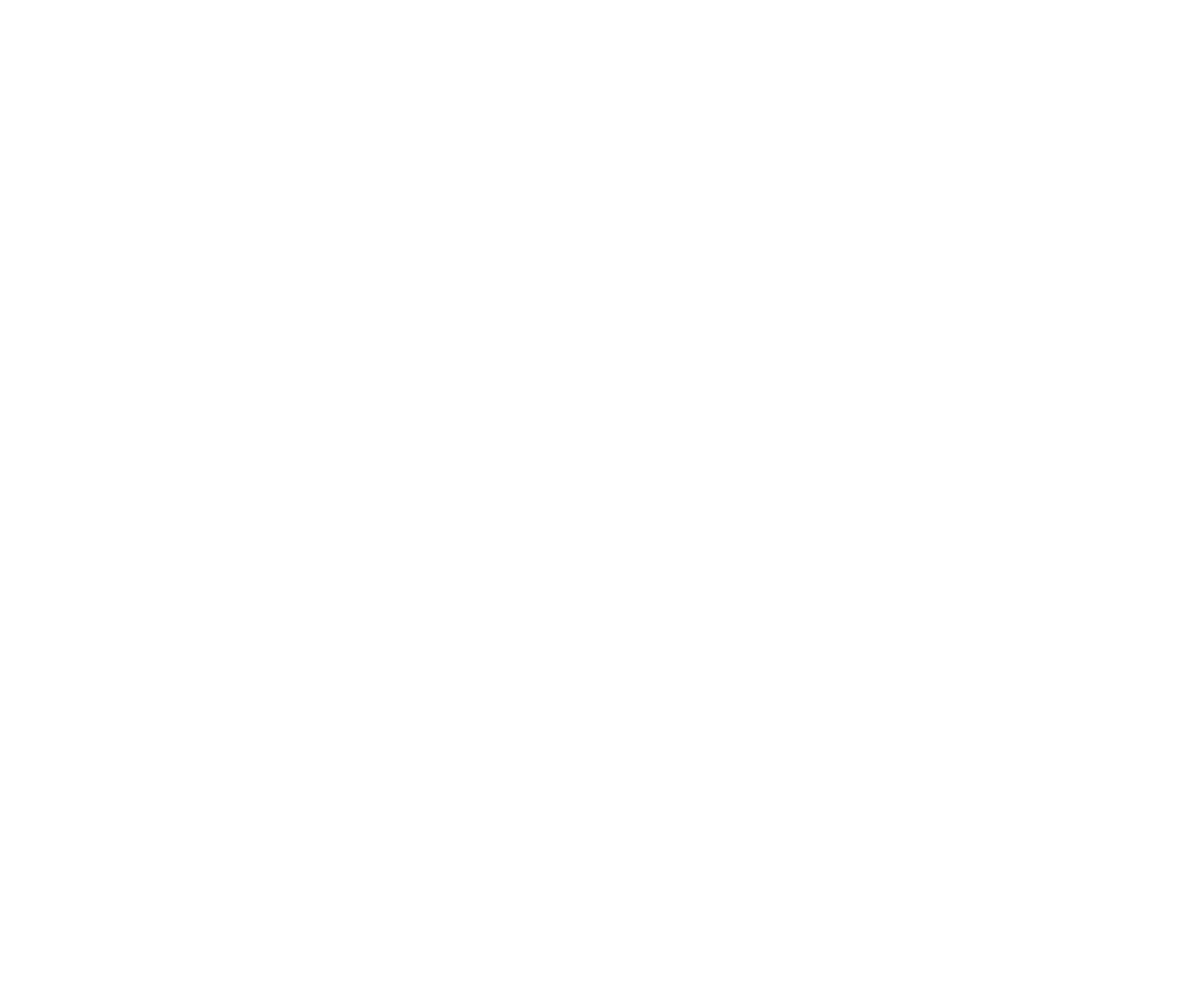

✅ Échantillons d'images générées sauvegardés dans c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs\generated_samples_per_class.png


In [20]:
print("Vérification des images synthétiques générées par le Class Equalizer...")
print("="*60)

# Parcourir chaque classe pour compter les images augmentées
train_dir_root = os.path.join(StarGAN_dir, "train")
total_generated = 0

for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    class_path = os.path.join(train_dir_root, class_name)
    aug_images = [f for f in os.listdir(class_path) if f.startswith("aug_gen")]
    if len(aug_images) > 0:
        print(f"  {class_name}: {len(aug_images)} images augmentées")
        total_generated += len(aug_images)

print(f"\nTotal d'images synthétiques générées: {total_generated}")
print("="*60 + "\n")

# Afficher des échantillons d'images générées si disponibles
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()
sample_count = 0

for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    class_path = os.path.join(train_dir_root, class_name)
    aug_images = [f for f in os.listdir(class_path) if f.startswith("aug_gen")]
    
    if len(aug_images) > 0 and sample_count < 9:
        img_name = aug_images[0]  # Prendre la première image augmentée
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        
        axes[sample_count].imshow(img)
        axes[sample_count].set_title(f"Generated {class_name}")
        axes[sample_count].axis("off")
        sample_count += 1

# Cacher les axes non utilisés
for idx in range(sample_count, 9):
    axes[idx].axis("off")

plt.tight_layout()
sample_output_path = os.path.join(OUTPUT_DIR, "generated_samples_per_class.png")
plt.savefig(sample_output_path, dpi=100, bbox_inches='tight')
plt.show()
print(f"✅ Échantillons d'images générées sauvegardés dans {sample_output_path}")

## Étape 9.5 : Plan d'augmentation - Nombre d'images à créer par catégorie

In [21]:
print("\n" + "="*70)
print("📋 PLAN D'AUGMENTATION DES IMAGES PAR CATÉGORIE")
print("="*70)

# Récupérer la distribution actuelle des images en train
train_dir_root = os.path.join(StarGAN_dir, "train")
current_distribution = get_class_distribution(train_dir_root)

print("\n📊 DISTRIBUTION ACTUELLE (AVANT AUGMENTATION):")
print("-" * 70)

# Afficher la distribution actuelle et trouver le maximum
max_images = 0
for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    current_count = current_distribution.get(class_name, 0)
    max_images = max(max_images, current_count)
    soil_types = {
        "type1": "Alluvial Soil",
        "type2": "Arid Soil",
        "type3": "Black Soil",
        "type4": "Laterite Soil",
        "type5": "Mountain Soil",
        "type6": "Red Soil",
        "type7": "Yellow Soil"
    }
    print(f"  {class_name} ({soil_types.get(class_name, 'Unknown')}): {current_count:4d} images")

print("-" * 70)
print(f"🎯 NOMBRE MAXIMUM D'IMAGES PAR CLASSE: {max_images}")

print("\n📈 IMAGES À CRÉER PAR CATÉGORIE (PLAN D'AUGMENTATION):")
print("-" * 70)

# Calculer et afficher le plan d'augmentation
total_to_generate = 0
augmentation_plan = {}

for class_idx in range(1, 8):
    class_name = f"type{class_idx}"
    current_count = current_distribution.get(class_name, 0)
    images_to_create = max_images - current_count
    augmentation_plan[class_name] = images_to_create
    total_to_generate += images_to_create
    
    soil_types = {
        "type1": "Alluvial Soil",
        "type2": "Arid Soil",
        "type3": "Black Soil",
        "type4": "Laterite Soil",
        "type5": "Mountain Soil",
        "type6": "Red Soil",
        "type7": "Yellow Soil"
    }
    
    status = "✅ (Déjà équilibré)" if images_to_create == 0 else "⚠️ (À augmenter)"
    print(f"  {class_name} ({soil_types.get(class_name, 'Unknown'):20s}): "
          f"Créer {images_to_create:3d} images {status}")

print("-" * 70)
print(f"📊 TOTAL À GÉNÉRER: {total_to_generate} images synthétiques")

print("\n📋 RÉSUMÉ FINAL ATTENDU (APRÈS AUGMENTATION):")
print("-" * 70)
print(f"  Chaque classe aura: {max_images} images")
print(f"  Total images en train (équilibré): {max_images * 7} images")
print("="*70 + "\n")


📋 PLAN D'AUGMENTATION DES IMAGES PAR CATÉGORIE

📊 DISTRIBUTION ACTUELLE (AVANT AUGMENTATION):
----------------------------------------------------------------------
  type1 (Alluvial Soil):   36 images
  type2 (Arid Soil):  198 images
  type3 (Black Soil):  178 images
  type4 (Laterite Soil):  153 images
  type5 (Mountain Soil):  140 images
  type6 (Red Soil):   76 images
  type7 (Yellow Soil):   48 images
----------------------------------------------------------------------
🎯 NOMBRE MAXIMUM D'IMAGES PAR CLASSE: 198

📈 IMAGES À CRÉER PAR CATÉGORIE (PLAN D'AUGMENTATION):
----------------------------------------------------------------------
  type1 (Alluvial Soil       ): Créer 162 images ⚠️ (À augmenter)
  type2 (Arid Soil           ): Créer   0 images ✅ (Déjà équilibré)
  type3 (Black Soil          ): Créer  20 images ⚠️ (À augmenter)
  type4 (Laterite Soil       ): Créer  45 images ⚠️ (À augmenter)
  type5 (Mountain Soil       ): Créer  58 images ⚠️ (À augmenter)
  type6 (Red Soil 

## Étape 10 : Appliquer le Class Equalizer et créer le dataset augmenté pour la classification

In [22]:
print("="*60)
print("🚀 ÉTAPE 10: ÉGALISATION DES CLASSES AVEC LE STARGAN")
print("="*60)

# Appliquer le Class Equalizer sur le dossier train
train_dir_root = os.path.join(StarGAN_dir, "train")
print("\nApplication du Class Equalizer...")
class_equalizer(G, train_loader, device, num_domains, train_dir_root)

print("\n" + "="*60)
print("✨ Égalisation des classes terminée!")
print("="*60)

🚀 ÉTAPE 10: ÉGALISATION DES CLASSES AVEC LE STARGAN

Application du Class Equalizer...

🔄 ÉQUILIBRAGE DES CLASSES (CLASS EQUALIZER)
Distribution initiale des images par classe:
  type1: 36 images
  type2: 198 images
  type3: 178 images
  type4: 153 images
  type5: 140 images
  type6: 76 images
  type7: 48 images

📊 Classe avec le plus d'images: 198 images

🎯 Génération pour type1: 162 images manquantes
Images générées pour la classe 0: 162 images
✅ type2: 198 images (maximum atteint)

🎯 Génération pour type3: 20 images manquantes
Images générées pour la classe 2: 20 images

🎯 Génération pour type4: 45 images manquantes
Images générées pour la classe 3: 45 images

🎯 Génération pour type5: 58 images manquantes
Images générées pour la classe 4: 58 images

🎯 Génération pour type6: 122 images manquantes
Images générées pour la classe 5: 122 images

🎯 Génération pour type7: 150 images manquantes
Images générées pour la classe 6: 150 images

✨ VÉRIFICATION FINALE
  type1: 198 images
  type2: 

## Étape 11 : Renommer les dossiers train/test par leur type de sol

In [23]:
# Mapping inverse pour renommer les dossiers
type_to_soil_name = {
    "type1": "Alluvial_Soil",
    "type2": "Arid_Soil",
    "type3": "Black_Soil",
    "type4": "Laterite_Soil",
    "type5": "Mountain_Soil",
    "type6": "Red_Soil",
    "type7": "Yellow_Soil"
}

print("\n" + "="*60)
print("🔄 RENOMMAGE DES DOSSIERS PAR TYPE DE SOL")
print("="*60)

# Renommer dans le dossier train
train_dir = os.path.join(StarGAN_dir, "train")
print("\n📁 Renommage dans TRAIN:")
for type_name, soil_name in type_to_soil_name.items():
    old_path = os.path.join(train_dir, type_name)
    new_path = os.path.join(train_dir, soil_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        img_count = len([f for f in os.listdir(new_path) if f.endswith('.jpg')])
        print(f"  ✅ {type_name} → {soil_name} ({img_count} images)")

# Renommer dans le dossier test
test_dir = os.path.join(StarGAN_dir, "test")
print("\n📁 Renommage dans TEST:")
for type_name, soil_name in type_to_soil_name.items():
    old_path = os.path.join(test_dir, type_name)
    new_path = os.path.join(test_dir, soil_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        img_count = len([f for f in os.listdir(new_path) if f.endswith('.jpg')])
        print(f"  ✅ {type_name} → {soil_name} ({img_count} images)")

print("\n" + "="*60)
print("✨ Renommage terminé!")
print("="*60 + "\n")


🔄 RENOMMAGE DES DOSSIERS PAR TYPE DE SOL

📁 Renommage dans TRAIN:
  ✅ type1 → Alluvial_Soil (198 images)
  ✅ type2 → Arid_Soil (198 images)
  ✅ type3 → Black_Soil (198 images)
  ✅ type4 → Laterite_Soil (198 images)
  ✅ type5 → Mountain_Soil (198 images)
  ✅ type6 → Red_Soil (198 images)
  ✅ type7 → Yellow_Soil (198 images)

📁 Renommage dans TEST:
  ✅ type1 → Alluvial_Soil (15 images)
  ✅ type2 → Arid_Soil (86 images)
  ✅ type3 → Black_Soil (77 images)
  ✅ type4 → Laterite_Soil (66 images)
  ✅ type5 → Mountain_Soil (61 images)
  ✅ type6 → Red_Soil (32 images)
  ✅ type7 → Yellow_Soil (21 images)

✨ Renommage terminé!



## Étape 12 : Visualiser l'équilibre des classes

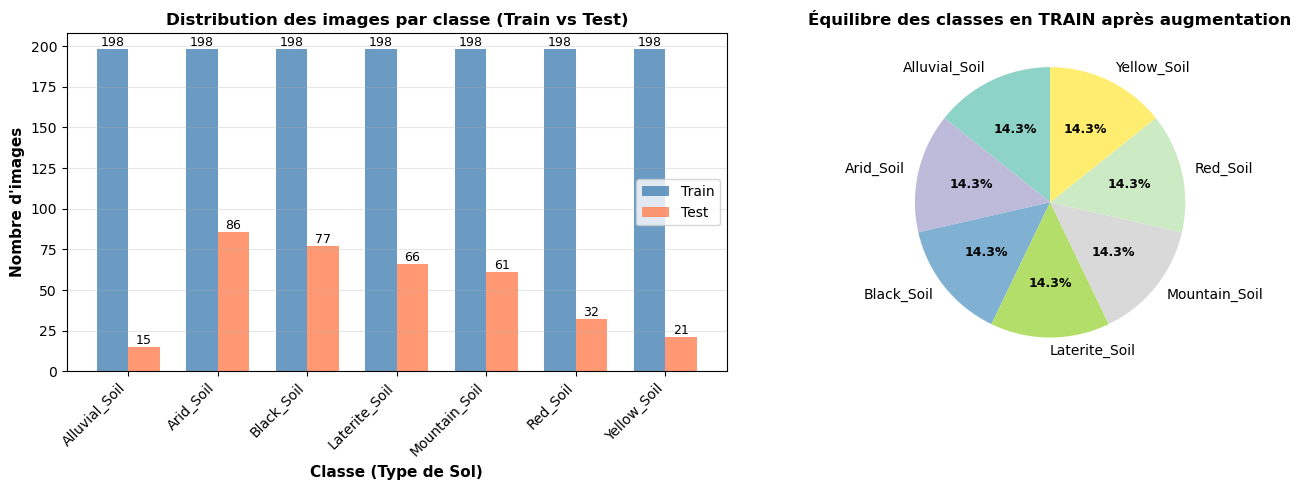


✅ Visualisation de l'équilibre des classes sauvegardée
📁 Fichier sauvegardé: c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs\class_balance_visualization.png
Total images TRAIN: 1386
Total images TEST: 358
Proportion TRAIN/TEST: 1386/358



In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer les distributions depuis StarGAN_dir
train_dist = get_class_distribution(os.path.join(StarGAN_dir, "train"))
test_dist = get_class_distribution(os.path.join(StarGAN_dir, "test"))

# Préparer les données pour le graphique
class_names = sorted(train_dist.keys())
train_counts = [train_dist[name] for name in class_names]
test_counts = [test_dist[name] for name in class_names]

# Créer le graphique
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution train/test par classe
x = np.arange(len(class_names))
width = 0.35

ax = axes[0]
bars1 = ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, test_counts, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Classe (Type de Sol)', fontsize=11, fontweight='bold')
ax.set_ylabel('Nombre d\'images', fontsize=11, fontweight='bold')
ax.set_title('Distribution des images par classe (Train vs Test)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# Graphique 2: Équilibre de la distribution train
ax = axes[1]
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
wedges, texts, autotexts = ax.pie(train_counts, labels=class_names, autopct='%1.1f%%',
                                    colors=colors, startangle=90)
ax.set_title('Équilibre des classes en TRAIN après augmentation', fontsize=12, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

plt.tight_layout()
balance_output_path = os.path.join(OUTPUT_DIR, "class_balance_visualization.png")
plt.savefig(balance_output_path, dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✅ Visualisation de l'équilibre des classes sauvegardée")
print("="*60)
print(f"📁 Fichier sauvegardé: {balance_output_path}")
print(f"Total images TRAIN: {sum(train_counts)}")
print(f"Total images TEST: {sum(test_counts)}")
print(f"Proportion TRAIN/TEST: {sum(train_counts)}/{sum(test_counts)}")
print("="*60 + "\n")

## Résumé Final - Localisation des fichiers générés

In [30]:
print("\n" + "="*70)
print("📁 RÉSUMÉ DE LA STRUCTURE DES FICHIERS GÉNÉRÉS")
print("="*70)

print("\n✅ DOSSIER DE SORTIE PRINCIPAL:")
print(f"   📂 {OUTPUT_DIR}")

print("\n📊 Fichiers générés dans le dossier outputs:")
print("-" * 70)

# Modèles
models_dir = os.path.join(OUTPUT_DIR, "models")
if os.path.exists(models_dir):
    model_files = os.listdir(models_dir)
    print(f"\n🤖 Modèles ({len(model_files)} fichiers):")
    for f in sorted(model_files):
        file_path = os.path.join(models_dir, f)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Taille en MB
        print(f"   • {f} ({file_size:.2f} MB)")

# Samples
samples_dir = os.path.join(OUTPUT_DIR, "samples")
if os.path.exists(samples_dir):
    sample_files = os.listdir(samples_dir)
    print(f"\n🖼️  Samples ({len(sample_files)} fichiers):")
    for f in sorted(sample_files):
        print(f"   • {f}")

# Logs
logs_dir = os.path.join(OUTPUT_DIR, "training_logs")
if os.path.exists(logs_dir):
    log_files = os.listdir(logs_dir)
    print(f"\n📈 Logs TensorBoard ({len(log_files)} fichier(s)):")
    for f in sorted(log_files):
        print(f"   • {f}")

# Visualisations
viz_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')]
if viz_files:
    print(f"\n📊 Visualisations ({len(viz_files)} fichier(s)):")
    for f in sorted(viz_files):
        print(f"   • {f}")

print("\n" + "="*70)
print("✨ RÉSUMÉ DES DOSSIERS DE DONNÉES:")
print("-" * 70)
print(f"\n📂 Dataset StarGAN (train/test avec classes équilibrées): {StarGAN_dir}")
print(f"📂 Outputs générés: {OUTPUT_DIR}")

print("\n" + "="*70)
print("🎯 COMMENT ACCÉDER AUX FICHIERS:")
print("-" * 70)
print(f"\n1️⃣  Pour voir les modèles entraînés:")
print(f"   → Naviguez vers: {models_dir}")
print(f"\n2️⃣  Pour voir les logs TensorBoard:")
print(f"   → Exécutez: tensorboard --logdir={logs_dir}")
print(f"\n3️⃣  Pour voir les visualisations:")
print(f"   → Naviguez vers: {OUTPUT_DIR}")
print(f"\n4️⃣  Pour voir les samples générés:")
print(f"   → Naviguez vers: {samples_dir}")
print(f"\n5️⃣  Pour utiliser les images équilibrées:")
print(f"   → Train: {os.path.join(StarGAN_dir, 'train')}")
print(f"   → Test:  {os.path.join(StarGAN_dir, 'test')}")

print("\n" + "="*70 + "\n")


📁 RÉSUMÉ DE LA STRUCTURE DES FICHIERS GÉNÉRÉS

✅ DOSSIER DE SORTIE PRINCIPAL:
   📂 c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\outputs

📊 Fichiers générés dans le dossier outputs:
----------------------------------------------------------------------

🤖 Modèles (6 fichiers):
   • D_epoch_0.pth (0.15 MB)
   • D_epoch_10.pth (0.15 MB)
   • D_epoch_20.pth (0.15 MB)
   • G_epoch_0.pth (1.51 MB)
   • G_epoch_10.pth (1.51 MB)
   • G_epoch_20.pth (1.51 MB)

🖼️  Samples (3 fichiers):
   • epoch_0.png
   • epoch_10.png
   • epoch_20.png

📈 Logs TensorBoard (1 fichier(s)):
   • 20260119-215944

📊 Visualisations (2 fichier(s)):
   • class_balance_visualization.png
   • generated_samples_per_class.png

✨ RÉSUMÉ DES DOSSIERS DE DONNÉES:
----------------------------------------------------------------------

📂 Dataset StarGAN (train/test avec classes équilibrées): c:\Users\alera\Desktop\ENTPE\Deep Learning\Project\data\StarGAN-Dataset
📂 Outputs générés: c:\Users\alera\Desktop\ENTPE\Deep Lear

## Evaluation on Test Set: CNN and Transformer Models

In [31]:
# Setup paths and imports for evaluation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import timm
from pathlib import Path

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Create output directory for StarGAN results
stargan_results_dir = Path('..') / 'results' / 'StarGAN'
stargan_results_dir.mkdir(parents=True, exist_ok=True)
print(f"StarGAN results directory: {stargan_results_dir}")

# Define soil types
soil_types = ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']
num_classes = len(soil_types)
print(f"Number of classes: {num_classes}")

Device: cuda
StarGAN results directory: ..\results\StarGAN
Number of classes: 7


In [34]:
# Load test data directly from the StarGAN test split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path

test_root = Path(StarGAN_dir) / 'test'
type_to_soil_name = {v: k for k, v in folder_mapping.items()}
valid_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

class EvalFolderDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Collect all test samples once so both models use the same ordering
test_samples = []
for domain_dir in sorted(test_root.iterdir()):
    if not domain_dir.is_dir():
        continue
    soil_name = type_to_soil_name.get(domain_dir.name)
    if soil_name not in soil_types:
        continue
    label_idx = soil_types.index(soil_name)
    for img_path in sorted(domain_dir.iterdir()):
        if img_path.suffix.lower() in valid_exts:
            test_samples.append((img_path, label_idx))

if not test_samples:
    raise RuntimeError(f"No test images found in {test_root}. Ensure the StarGAN split was generated.")

# CNN Dataset (256x256 tensor without extra normalization)
cnn_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Transformer Dataset (224x224 with ImageNet normalization)
transformer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cnn_test_dataset = EvalFolderDataset(test_samples, transform=cnn_transform)
transformer_test_dataset = EvalFolderDataset(test_samples, transform=transformer_transform)

EVAL_BATCH_SIZE = 32
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False)
transformer_test_loader = DataLoader(transformer_test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False)

print(f"Test dataset created: {len(test_samples)} images")
print(f"CNN test loader: {len(cnn_test_loader)} batches")
print(f"Transformer test loader: {len(transformer_test_loader)} batches")

Test dataset created: 360 images
CNN test loader: 12 batches
Transformer test loader: 12 batches


In [ ]:
# Load CNN Model (SimpleCNN)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(512, 256)
        self.drop = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

cnn_model_path = Path('..') / 'models' / 'best_model'
cnn_model = SimpleCNN(num_classes=num_classes).to(device)

if cnn_model_path.exists():
    print(f"Loading CNN weights from {cnn_model_path}")
    checkpoint = torch.load(cnn_model_path, map_location=device)
    state_dict = checkpoint['model_state_dict'] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
    missing, unexpected = cnn_model.load_state_dict(state_dict, strict=False)
    if missing or unexpected:
        print(f"Warning: Missing keys {missing} | Unexpected keys {unexpected}")
else:
    print(f"CNN model not found at {cnn_model_path}. Using randomly initialized weights.")

cnn_model.eval()
cnn_predictions = []
cnn_true_labels = []

with torch.no_grad():
    for images, labels in cnn_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        cnn_predictions.extend(predicted.cpu().numpy())
        cnn_true_labels.extend(labels.cpu().numpy())

✗ CNN model not found at ..\model\best_model


In [ ]:
# Load Transformer Model
transformer_model_path = Path('..') / 'models' / 'best_model_transformer'
transformer_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=num_classes)
transformer_model.to(device)

if transformer_model_path.exists():
    print(f"Loading Transformer weights from {transformer_model_path}")
    checkpoint = torch.load(transformer_model_path, map_location=device)
    state_dict = checkpoint['model_state_dict'] if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint else checkpoint
    transformer_model.load_state_dict(state_dict, strict=False)
else:
    print(f"Transformer model not found at {transformer_model_path}. Using randomly initialized weights.")

transformer_model.eval()
transformer_predictions = []
transformer_true_labels = []

with torch.no_grad():
    for images, labels in transformer_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = transformer_model(images)
        _, predicted = torch.max(outputs, 1)
        transformer_predictions.extend(predicted.cpu().numpy())
        transformer_true_labels.extend(labels.cpu().numpy())

✗ Transformer model not found at ..\model\best_model_transformer


In [37]:
# Evaluate CNN on test set
print("\n" + "="*70)
print("Evaluating CNN on test set...")
print("="*70)

cnn_predictions = []
cnn_true_labels = []

with torch.no_grad():
    for images, labels in cnn_test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        cnn_predictions.extend(predicted.cpu().numpy())
        cnn_true_labels.extend(labels.numpy())

cnn_predictions = np.array(cnn_predictions)
cnn_true_labels = np.array(cnn_true_labels)

# Calculate CNN metrics
cnn_accuracy = accuracy_score(cnn_true_labels, cnn_predictions)
cnn_precision = precision_score(cnn_true_labels, cnn_predictions, average='weighted', zero_division=0)
cnn_recall = recall_score(cnn_true_labels, cnn_predictions, average='weighted', zero_division=0)
cnn_f1 = f1_score(cnn_true_labels, cnn_predictions, average='weighted', zero_division=0)

print(f"\nCNN Model Performance:")
print(f"  Accuracy:  {cnn_accuracy:.4f}")
print(f"  Precision: {cnn_precision:.4f}")
print(f"  Recall:    {cnn_recall:.4f}")
print(f"  F1-Score:  {cnn_f1:.4f}")


Evaluating CNN on test set...


NameError: name 'cnn_model' is not defined

In [ ]:
# Evaluate Transformer on test set
print("\n" + "="*70)
print("Evaluating Transformer on test set...")
print("="*70)

transformer_predictions = []
transformer_true_labels = []

with torch.no_grad():
    for images, labels in transformer_test_loader:
        images = images.to(device)
        outputs = transformer_model(images)
        _, predicted = torch.max(outputs, 1)
        transformer_predictions.extend(predicted.cpu().numpy())
        transformer_true_labels.extend(labels.numpy())

transformer_predictions = np.array(transformer_predictions)
transformer_true_labels = np.array(transformer_true_labels)

# Calculate Transformer metrics
transformer_accuracy = accuracy_score(transformer_true_labels, transformer_predictions)
transformer_precision = precision_score(transformer_true_labels, transformer_predictions, average='weighted', zero_division=0)
transformer_recall = recall_score(transformer_true_labels, transformer_predictions, average='weighted', zero_division=0)
transformer_f1 = f1_score(transformer_true_labels, transformer_predictions, average='weighted', zero_division=0)

print(f"\nTransformer Model Performance:")
print(f"  Accuracy:  {transformer_accuracy:.4f}")
print(f"  Precision: {transformer_precision:.4f}")
print(f"  Recall:    {transformer_recall:.4f}")
print(f"  F1-Score:  {transformer_f1:.4f}")

In [ ]:
# Plot CNN Confusion Matrix
print("\n" + "="*70)
print("Generating visualizations...")
print("="*70)

cnn_cm = confusion_matrix(cnn_true_labels, cnn_predictions)
cnn_cm_normalized = cnn_cm.astype('float') / cnn_cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# CNN Confusion Matrix (counts)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=soil_types, yticklabels=soil_types, ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
axes[0].set_title('CNN - Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# CNN Confusion Matrix (normalized)
sns.heatmap(cnn_cm_normalized, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=soil_types, yticklabels=soil_types, ax=axes[1])
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
axes[1].set_title('CNN - Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(stargan_results_dir / 'cnn_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ CNN confusion matrices saved")
plt.show()

In [ ]:
# Plot Transformer Confusion Matrix
transformer_cm = confusion_matrix(transformer_true_labels, transformer_predictions)
transformer_cm_normalized = transformer_cm.astype('float') / transformer_cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Transformer Confusion Matrix (counts)
sns.heatmap(transformer_cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=soil_types, yticklabels=soil_types, ax=axes[0])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
axes[0].set_title('Transformer - Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Transformer Confusion Matrix (normalized)
sns.heatmap(transformer_cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=soil_types, yticklabels=soil_types, ax=axes[1])
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
axes[1].set_title('Transformer - Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(stargan_results_dir / 'transformer_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("✓ Transformer confusion matrices saved")
plt.show()

In [ ]:
# Compare CNN vs Transformer
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Per-class metrics for CNN
cnn_per_class_acc = cnn_cm.diagonal() / cnn_cm.sum(axis=1)
cnn_per_class_f1 = f1_score(cnn_true_labels, cnn_predictions, average=None)

# Per-class metrics for Transformer
transformer_per_class_acc = transformer_cm.diagonal() / transformer_cm.sum(axis=1)
transformer_per_class_f1 = f1_score(transformer_true_labels, transformer_predictions, average=None)

# Plot 1: Per-class Accuracy
x_pos = np.arange(len(soil_types))
width = 0.35
axes[0, 0].bar(x_pos - width/2, cnn_per_class_acc, width, label='CNN', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, transformer_per_class_acc, width, label='Transformer', alpha=0.8)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(soil_types, rotation=45, ha='right')
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Per-Class Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Per-class F1-Score
axes[0, 1].bar(x_pos - width/2, cnn_per_class_f1, width, label='CNN', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, transformer_per_class_f1, width, label='Transformer', alpha=0.8)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(soil_types, rotation=45, ha='right')
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('Per-Class F1-Score Comparison', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Overall Metrics Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cnn_scores = [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]
transformer_scores = [transformer_accuracy, transformer_precision, transformer_recall, transformer_f1]

x_pos = np.arange(len(metrics))
axes[1, 0].bar(x_pos - width/2, cnn_scores, width, label='CNN', alpha=0.8, color='steelblue')
axes[1, 0].bar(x_pos + width/2, transformer_scores, width, label='Transformer', alpha=0.8, color='coral')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Overall Metrics Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1.0])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (c, t) in enumerate(zip(cnn_scores, transformer_scores)):
    axes[1, 0].text(i - width/2, c + 0.02, f'{c:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1, 0].text(i + width/2, t + 0.02, f'{t:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Summary Table
axes[1, 1].axis('off')
summary_data = [
    ['Metric', 'CNN', 'Transformer'],
    ['Accuracy', f'{cnn_accuracy:.4f}', f'{transformer_accuracy:.4f}'],
    ['Precision', f'{cnn_precision:.4f}', f'{transformer_precision:.4f}'],
    ['Recall', f'{cnn_recall:.4f}', f'{transformer_recall:.4f}'],
    ['F1-Score', f'{cnn_f1:.4f}', f'{transformer_f1:.4f}']
]
table = axes[1, 1].table(cellText=summary_data, cellLoc='center', loc='center',
                         colWidths=[0.3, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight better scores
for i in range(1, 5):
    cnn_val = float(summary_data[i][1])
    transformer_val = float(summary_data[i][2])
    if cnn_val > transformer_val:
        table[(i, 1)].set_facecolor('#c1ffc1')
    elif transformer_val > cnn_val:
        table[(i, 2)].set_facecolor('#c1ffc1')

axes[1, 1].set_title('Performance Summary', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(stargan_results_dir / 'cnn_vs_transformer_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Comparison plots saved")
plt.show()

In [ ]:
# Generate final evaluation report
report_content = """
========================================
StarGAN Evaluation Report
Test Set Performance Comparison
========================================

OVERALL METRICS
================

CNN Model:
  Accuracy:  {cnn_acc:.4f}
  Precision: {cnn_prec:.4f}
  Recall:    {cnn_rec:.4f}
  F1-Score:  {cnn_f1_score:.4f}

Transformer Model:
  Accuracy:  {trans_acc:.4f}
  Precision: {trans_prec:.4f}
  Recall:    {trans_rec:.4f}
  F1-Score:  {trans_f1_score:.4f}

BEST PERFORMING MODEL: {best_model}
Performance Gain: {gain:.4f} ({gain_pct:.2f}%)


PER-CLASS ACCURACY
===================
""".format(
    cnn_acc=cnn_accuracy,
    cnn_prec=cnn_precision,
    cnn_rec=cnn_recall,
    cnn_f1_score=cnn_f1,
    trans_acc=transformer_accuracy,
    trans_prec=transformer_precision,
    trans_rec=transformer_recall,
    trans_f1_score=transformer_f1,
    best_model='CNN' if cnn_f1 >= transformer_f1 else 'Transformer',
    gain=abs(cnn_f1 - transformer_f1),
    gain_pct=100 * abs(cnn_f1 - transformer_f1)
)

# Add per-class accuracy
for soil_type, cnn_acc_class, trans_acc_class in zip(soil_types, cnn_per_class_acc, transformer_per_class_acc):
    report_content += f"\n{soil_type:20s} | CNN: {cnn_acc_class:.4f} | Transformer: {trans_acc_class:.4f}"

# Save report
report_path = stargan_results_dir / 'evaluation_report.txt'
with open(report_path, 'w') as f:
    f.write(report_content)

print(report_content)
print(f"\n✓ Full evaluation report saved to {report_path}")

# Create summary statistics file
stats_dict = {
    'CNN': {
        'Accuracy': float(cnn_accuracy),
        'Precision': float(cnn_precision),
        'Recall': float(cnn_recall),
        'F1-Score': float(cnn_f1),
        'Per-Class Accuracy': {soil: float(acc) for soil, acc in zip(soil_types, cnn_per_class_acc)}
    },
    'Transformer': {
        'Accuracy': float(transformer_accuracy),
        'Precision': float(transformer_precision),
        'Recall': float(transformer_recall),
        'F1-Score': float(transformer_f1),
        'Per-Class Accuracy': {soil: float(acc) for soil, acc in zip(soil_types, transformer_per_class_acc)}
    }
}

import json
stats_path = stargan_results_dir / 'evaluation_stats.json'
with open(stats_path, 'w') as f:
    json.dump(stats_dict, f, indent=2)

print(f"✓ Statistics saved to {stats_path}")

# List all saved files
print("\n" + "="*50)
print("Saved Files in results/StarGAN:")
print("="*50)
for file in sorted(stargan_results_dir.glob('*')):
    if file.is_file():
        print(f"  ✓ {file.name}")